<a href="https://colab.research.google.com/github/Jeoniee/spartaAI/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.55MB/s]



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


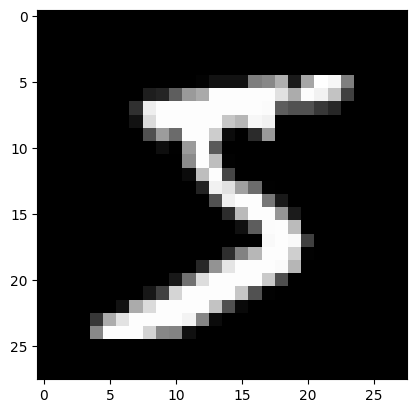

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [4]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [8]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) #1 -> 10으로 변경함

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [9]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [12]:
# 모델 학습 함수
n_epochs = 100
batch_size = 256
lr = 0.001

train_accs = []  # train 정확도 리스트
test_accs = []   # test 정확도 리스트

criterion = nn.CrossEntropyLoss()  # MSE 대신 CrossEntropyLoss 사용

def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    # 평가 모드로 설정 -> 너무 느려서 바꿔봄
    model.eval()

    with torch.no_grad():  # 평가 중에는 gradient 계산을 하지 않음
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt


for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = criterion(preds, labels)  # CrossEntropyLoss 사용
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

# Epoch마다 train과 test 정확도 계산
  model.eval()  # 모델을 평가 모드로 설정
  train_acc = accuracy(model, trainloader)  # train 데이터 정확도
  test_acc = accuracy(model, testloader)    # test 데이터 정확도

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")
  #print(f"Epoch {epoch+1}/{n_epochs} | Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

Epoch 1/100 | Loss: 708.0130 | Train Accuracy: 0.7408 | Test Accuracy: 0.7406
Epoch 2/100 | Loss: 705.0124 | Train Accuracy: 0.7414 | Test Accuracy: 0.7404
Epoch 3/100 | Loss: 702.1285 | Train Accuracy: 0.7418 | Test Accuracy: 0.7412
Epoch 4/100 | Loss: 699.4920 | Train Accuracy: 0.7423 | Test Accuracy: 0.7420
Epoch 5/100 | Loss: 696.6452 | Train Accuracy: 0.7431 | Test Accuracy: 0.7425
Epoch 6/100 | Loss: 694.1474 | Train Accuracy: 0.7435 | Test Accuracy: 0.7430
Epoch 7/100 | Loss: 691.6568 | Train Accuracy: 0.7443 | Test Accuracy: 0.7427
Epoch 8/100 | Loss: 689.3308 | Train Accuracy: 0.7449 | Test Accuracy: 0.7433
Epoch 9/100 | Loss: 687.0330 | Train Accuracy: 0.7451 | Test Accuracy: 0.7439
Epoch 10/100 | Loss: 684.6324 | Train Accuracy: 0.7457 | Test Accuracy: 0.7449
Epoch 11/100 | Loss: 682.4656 | Train Accuracy: 0.7462 | Test Accuracy: 0.7447
Epoch 12/100 | Loss: 680.0452 | Train Accuracy: 0.7464 | Test Accuracy: 0.7449
Epoch 13/100 | Loss: 678.0389 | Train Accuracy: 0.7470 | Test

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [29]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[ 0.0000,  0.0000,  0.0000,  6.8333,  0.0000, 10.2973,  0.0000,  0.0000,
          0.0000,  0.1191]], device='cuda:0', grad_fn=<ReluBackward0>)
5


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

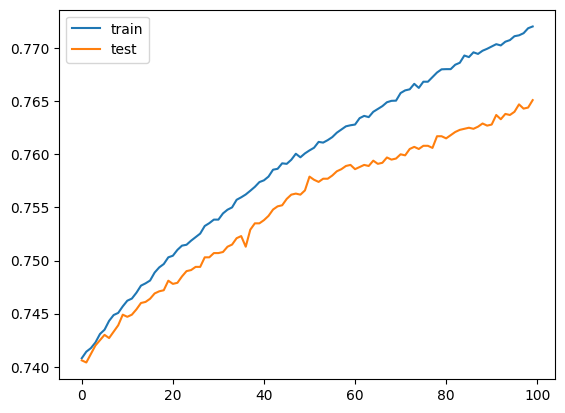

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()


# 함수 호출 -> 함수 정의 이후에 호출 할 것
plot_acc(train_accs, test_accs)

